In [ ]:
import pandas as pd
!pip install pytreebank

  Created wheel for pytreebank: filename=pytreebank-0.2.7-cp37-none-any.whl size=37070 sha256=baef29148ff8b0d3a55bc7899b78634bb65fa169b7652c66a74b9a1d1727600e
  Stored in directory: /root/.cache/pip/wheels/e0/b6/91/e9edcdbf464f623628d5c3aa9de28888c726e270b9a29f2368
Successfully built pytreebank


In [ ]:
import torch

In [ ]:
import pytreebank
import sys
import os


In [ ]:
out_path = os.path.join(sys.path[0], 'sst_{}.txt')
dataset = pytreebank.load_sst('./raw_data')

In [ ]:
for category in ['train', 'test', 'dev']:
    with open(out_path.format(category), 'w') as outfile:
        for item in dataset[category]:
            outfile.write("__label__{}\t{}\n".format(
                item.to_labeled_lines()[0][0] + 1,
                item.to_labeled_lines()[0][1]
            ))


In [ ]:
train_set=dataset['train']


In [ ]:
import pandas as pd

In [ ]:
df=pd.read_csv('./sst_train.txt',sep='\t',header=None,names=['label','text'])

In [ ]:
test_set=pd.read_csv('./sst_test.txt',sep='\t',header=None,names=['label','text'])

In [ ]:
val_set=pd.read_csv('./sst_dev.txt',sep='\t',header=None,names=['label','text'])

In [ ]:
df['label']=df['label'].str.replace('__label__','')


# New Section

In [ ]:
import random
import torch, torchtext
from torchtext import data

In [ ]:
# Manual Seed
SEED = 43
torch.manual_seed(SEED)

In [ ]:
#Tweet 
Review_text= torchtext.legacy.data.Field(sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True)
Label = torchtext.legacy.data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)

In [ ]:
fields = [('review',Review_text),('label',Label)]

In [ ]:
train_example = [torchtext.legacy.data.Example.fromlist([df.text[i],df.label[i]], fields) for i in range(df.shape[0])] 

In [ ]:
train_set=torchtext.legacy.data.Dataset(train_example,fields)

In [ ]:
test_set['label']=test_set['label'].str.replace('__label__','')
val_set['label']=val_set['label'].str.replace('__label__','')

In [ ]:
test_example = [torchtext.legacy.data.Example.fromlist([test_set.text[i],test_set.label[i]], fields) for i in range(test_set.shape[0])] 
val_example = [torchtext.legacy.data.Example.fromlist([val_set.text[i],val_set.label[i]], fields) for i in range(val_set.shape[0])] 

In [ ]:
tst_set=torchtext.legacy.data.Dataset(test_example,fields)
vl_set=torchtext.legacy.data.Dataset(val_example,fields)

In [ ]:
len(train_set),len(tst_set),len(vl_set)

(8544, 2210, 1101)

Looking at the distribution of different classes in the train_set, test_set and validation_set, I decided use the data augmentation techniques, like back translation, synonym replacement, random insertion, random deletion and random swap to make these datasets balanced.
Once that is done, pickling is done to store these datasets, rather than loading and creating them again and again.


In [ ]:
Review_text.build_vocab(train_set)
Label.build_vocab(train_set)

In [ ]:
print('Size of input vocab : ', len(Review_text.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Review_text.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  17165
Size of label vocab :  5
Top 10 words appreared repeatedly : [('.', 8041), (',', 7131), ('the', 6087), ('and', 4474), ('of', 4446), ('a', 4423), ('to', 3024), ('-', 2739), ("'s", 2544), ('is', 2540)]
Labels :  defaultdict(None, {'4': 0, '2': 1, '3': 2, '5': 3, '1': 4})


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
train_iterator = torchtext.legacy.data.BucketIterator(train_set, batch_size = 32, 
                                                            sort_key = lambda x: len(x.review),
                                                            sort_within_batch=True, device = device)

In [ ]:
valid_iterator = torchtext.legacy.data.BucketIterator(vl_set, batch_size = 32, 
                                                            sort_key = lambda x: len(x.review),
                                                            sort_within_batch=True, device = device)

In [ ]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    #pickle.dump(Tweet.vocab.stoi, tokens)
    pickle.dump(Review_text.vocab.stoi,tokens)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        
        super().__init__()          
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)
        # try using nn.GRU or nn.RNN here and compare their performances
        # try bidirectional and compare their performances
        
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        
        # text = [batch size, sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]
      
        # packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        packed_output, (hidden, cell) = self.encoder(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
    
        # Hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc(hidden)   
        
        # Final activation function softmax
        output = F.softmax(dense_outputs[0], dim=1)
            
        return output

In [ ]:
# Define hyperparameters
size_of_vocab=len(Review_text.vocab)
embedding_dim = 300
num_hidden_nodes = 100
num_output_nodes = 5
num_layers = 2
dropout = 0.2

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout = dropout)

In [ ]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(17165, 300)
  (encoder): LSTM(300, 100, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=100, out_features=5, bias=True)
)
The model has 5,391,605 trainable parameters


In [ ]:
device

device(type='cuda')

In [ ]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        #tweet, tweet_lengths = batch.tweet  
        review,review_length = batch.review
        
        # convert to 1D tensor
        #predictions = model(tweet, tweet_lengths).squeeze()  
        predictions=model(review,review_length)
        
        # compute the loss
        loss = criterion(predictions, batch.label)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            #tweet, tweet_lengths = batch.tweet
            review,review_length = batch.review
            
            # convert to 1d tensor
            predictions = model(review, review_length).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
device

device(type='cuda')

In [ ]:
import matplotlib.pyplot as plt
from IPython import display
plt.style.use('seaborn-white')
import numpy as np

In [ ]:
N_EPOCHS = 50
best_valid_loss = float('inf')
global plot_iter, plot_loss_train, plot_loss_val
plot_iter = np.zeros((0))
plot_loss_train = np.zeros((0))
plot_loss_val = np.zeros((0))
for epoch in range(N_EPOCHS):
     
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'\t epoch : {epoch} |\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')
    plot_iter = np.append(plot_iter, [epoch])
    plot_loss_train = np.append(plot_loss_train, [train_loss])
    plot_loss_val = np.append(plot_loss_val, [valid_loss])


	 epoch : 0 |	Train Loss: 1.582 | Train Acc: 26.99%
	 Val. Loss: 1.579 |  Val. Acc: 26.24% 

	 epoch : 1 |	Train Loss: 1.568 | Train Acc: 30.20%
	 Val. Loss: 1.571 |  Val. Acc: 29.81% 

	 epoch : 2 |	Train Loss: 1.540 | Train Acc: 35.33%
	 Val. Loss: 1.564 |  Val. Acc: 30.48% 

	 epoch : 3 |	Train Loss: 1.491 | Train Acc: 40.72%
	 Val. Loss: 1.562 |  Val. Acc: 32.05% 

	 epoch : 4 |	Train Loss: 1.444 | Train Acc: 45.40%
	 Val. Loss: 1.553 |  Val. Acc: 33.34% 

	 epoch : 5 |	Train Loss: 1.403 | Train Acc: 50.41%
	 Val. Loss: 1.552 |  Val. Acc: 33.11% 

	 epoch : 6 |	Train Loss: 1.363 | Train Acc: 55.75%
	 Val. Loss: 1.557 |  Val. Acc: 32.66% 

	 epoch : 7 |	Train Loss: 1.328 | Train Acc: 59.46%
	 Val. Loss: 1.560 |  Val. Acc: 31.59% 

	 epoch : 8 |	Train Loss: 1.298 | Train Acc: 62.25%
	 Val. Loss: 1.557 |  Val. Acc: 32.75% 

	 epoch : 9 |	Train Loss: 1.275 | Train Acc: 64.04%
	 Val. Loss: 1.556 |  Val. Acc: 32.93% 

	 epoch : 10 |	Train Loss: 1.256 | Train Acc: 65.59%
	 Val. Loss: 1.56

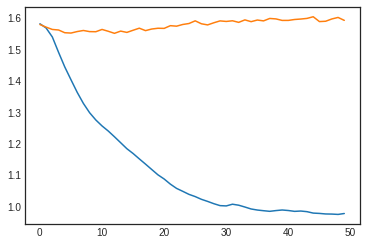

In [ ]:
plt.plot(plot_iter, plot_loss_train, plot_loss_val)
display.clear_output(wait=True)
plt.show()

In [ ]:
#load weights and tokenizer

path='./saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open('./tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 

import spacy
nlp = spacy.load('en')

def classify_tweet(tweet):
    
    categories = {0: "Positive",1:"Negative", 2:"Neutral", 3:"Very Positive", 4:"Very Negative"}
    
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(tweet)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor)
    print(prediction)
    print(prediction.max())
    print(categories)

    _, pred = torch.max(prediction, 1) 
    print (pred)
    print(pred.item())
    
    return categories[pred.item()]

In [ ]:
classify_tweet("never never never buy this product.")

tensor([[8.5380e-08, 9.9753e-01, 2.2836e-03, 3.2554e-05, 1.5444e-04]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor(0.9975, device='cuda:0', grad_fn=<MaxBackward1>)
{0: 'Positive', 1: 'Negative', 2: 'Neutral', 3: 'Very Positive', 4: 'Very Negative'}
tensor([1], device='cuda:0')
1


'Negative'